<h1 align="center"><i>Github Topics Details - Web Scraping Project</i></h1>

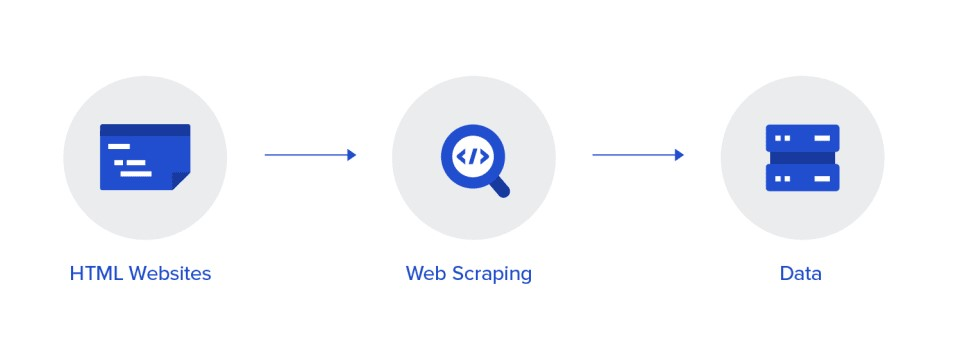

## Introduction:

Web scraping is the process of parsing and extracting data from the websites. It is very useful when we want to collect data from the websites for our work. 

I'm going to scrap Github's topics page(https://github.com/topics) to know-
* Different topics present on Github.
* For each topics,
    * topic titles, description and topic URL.
    * popular repository.
    * And for each popular repositories-
        * username(created by).
        * number of stars
        * URL of the repository.
        * number of times forked.
        * number of times commited.
        * last commited time.

<h6>Required data format:</h6>

|Topics|Descripton|Topic_URL|Popular_Repository|Username|Repository_URL|Number_Of_Stars|Forked_Count|Total_commits|Last_Commited|
|--|--|--|--|--|--|--|--|--|--|
|3D|--descr--|https://github.com/topics/3d| three.js|mrdoob |https://github.com/mrdoob/three.js |73300| 28708|37892|2021-08-07T10:36:49Z|
|||||||||||

<h6> Tools to be used:</h6> Python, Pandas, BeautifulSoup, Requests

## Let's scrap it...

<h3 align="center">Part I</h3>


First, let's import required libraries.

In [1]:
import requests           
from bs4 import BeautifulSoup
import pandas as pd

Now let's define a function which loads all the required topics pages and returns BeautifulSoup object.

In [2]:
def topics_pages_loader():
    page_content=''
    i=1
    while i<7:    # i<7 because there are only 6 topics pages
        url = 'https://github.com/topics?page={}'.format(i)
        r =requests.get(url)
        if r.status_code != 200:
            i-=1 #if status code!=200, it means failed to load the page. So reloading the page by decrementing the the i value
        else:
            page_content += '\n' + r.text
        i+=1
    doc = BeautifulSoup(page_content,'html.parser')
    return doc 

We have loaded all the required topics pages successfully.

We can see the required data in the below mentioned pic, we need to extract that from the respective tags.
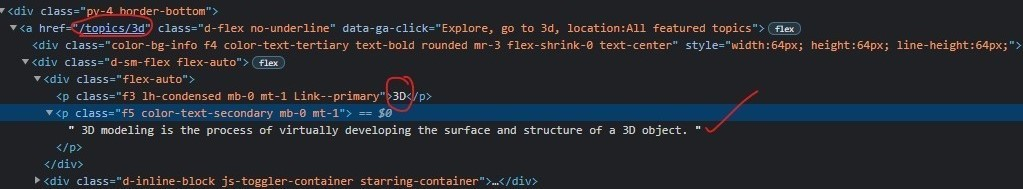

Now let's get all the 'Topics', 'Description' and 'Topics_URL' by defining the functions <code> get_topic_titles(doc) </code>, <code> get_topic_description(doc)</code> and <code> get_topic_urls(doc)</code> which return topics titles, description and topics URL respectively.

In [3]:
def get_topic_titles(doc):
    topic_selection_class= 'f3 lh-condensed mb-0 mt-1 Link--primary'
    topic_p_tags =doc.find_all('p',{'class':topic_selection_class})
    topic_titles =[]
    for tag in topic_p_tags:
        topic_titles.append(tag.text)
    return topic_titles

def get_topic_description(doc):
    desc_selection_class ='f5 color-text-secondary mb-0 mt-1'
    desc_ptags =doc.find_all('p',{'class':desc_selection_class})
    topic_descs =[]
    for tag in desc_ptags:
        topic_descs.append(tag.text.strip())
    return topic_descs
        
def get_topic_urls(doc):
    link_selection_class = 'd-flex no-underline'
    topic_link_tags =doc.find_all('a',{'class':link_selection_class})
    topic_urls =[]
    base_url ='https://github.com'
    for tag in topic_link_tags:
        topic_urls.append(base_url + tag['href'])
    return topic_urls

Now let's define a function <code>scrape_topics()</code> which returns the dataframe containing the columns 'Topics', 'Description', and 'Topic_URL'.

In [4]:
def scrape_topics():
    doc = topics_pages_loader()
    topics_dict = {
        'Topics': get_topic_titles(doc),
        'Description': get_topic_description(doc),
        'Topic_URL': get_topic_urls(doc)
    }
    return pd.DataFrame(topics_dict)

In [5]:
df_topics = scrape_topics()
df_topics.head()

Topics                                        Description  \
0         3D  3D modeling is the process of virtually develo...   
1       Ajax  Ajax is a technique for creating interactive w...   
2  Algorithm  Algorithms are self-contained sequences that c...   
3        Amp  Amp is a non-blocking concurrency framework fo...   
4    Android  Android is an operating system built by Google...   

                             Topic_URL  
0         https://github.com/topics/3d  
1       https://github.com/topics/ajax  
2  https://github.com/topics/algorithm  
3      https://github.com/topics/amphp  
4    https://github.com/topics/android

This is how our required semi-dataframe looks like. We have scraped first 3 columns which gives us the basic informations of the topics. 

This is not complete CSV file we wanted but we can store this also as another CSV file which basically gives us the basic informations of the topics. 

We can store this in a CSV format as shown below.

In [6]:
df_topics.to_csv('Github_topics.csv',index=False)

<h3 align="center">Part II</h3>


Now let's gather some data about popular repositories for each topics.

We can utilize the 'Topic_URL' column from the above dataframe to get some of the required information of the popular repositories.

In [7]:
topic_urls = df_topics['Topic_URL']

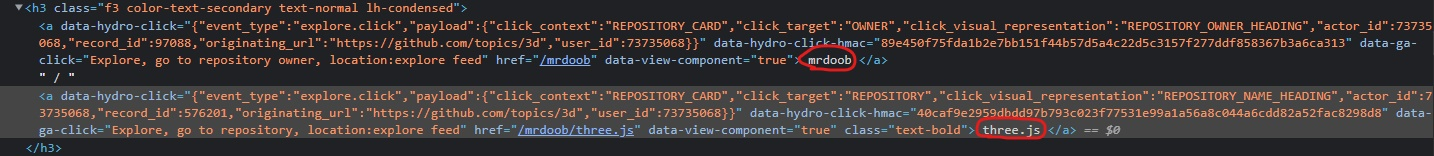

As we can see that repository name and username are present in <code>h3</code> tag, let's define a function which returns us these values. And also let's get the repository URL from the same function only.

In [8]:
def get_repo_info(h3_tags):
    atags = h3_tags.find_all('a')
    username = atags[0].text.strip()
    repo_name = atags[1].text.strip()
    repo_url ='https://github.com' + atags[1]['href']
    
    return username,repo_name,repo_url

The function <code>popular_repo_info()</code> loads each topics pages and get the popular repository(most starred) then returns 'Popular_Repository', 'Username' and 'Repo_URL'.

In [9]:
def popular_repo_info():
    repo_details ={'Popular_repository(most_starred)':[],'Repo_Username':[],'Repo_URL':[]}
    i=0
    while i<len(topic_urls):
        url = topic_urls[i] + '?o=desc&s=stars'
        r =requests.get(url)
        if r.status_code !=200:
            i-=1
        else:     
            doc = BeautifulSoup(r.text,'html.parser')

            h3_tags = doc.find_all('h3',{'class':'f3 color-text-secondary text-normal lh-condensed'}, limit=1)

            repo_info = get_repo_info(h3_tags[0])
            repo_details['Repo_Username'].append(repo_info[0])
            repo_details['Popular_repository(most_starred)'].append(repo_info[1])
            repo_details['Repo_URL'].append(repo_info[2])
        i+=1
    return pd.DataFrame(repo_details)

In [10]:
df_popular_repo = popular_repo_info()
df_popular_repo.head()

Popular_repository(most_starred) Repo_Username  \
0                         three.js        mrdoob   
1                  infinite-scroll     metafizzy   
2      coding-interview-university       jwasham   
3                              amp         amphp   
4                          flutter       flutter   

                                            Repo_URL  
0                 https://github.com/mrdoob/three.js  
1       https://github.com/metafizzy/infinite-scroll  
2  https://github.com/jwasham/coding-interview-un...  
3                       https://github.com/amphp/amp  
4                 https://github.com/flutter/flutter

Now we have the basic informations of the popular repositories like 'Popular_Repository', 'Username' and 'Repo_URL'. Let's get some other informations for these popular repositories like 'Number_Of_Stars','Forked_Count', 'Total_Commits' and 'Last_Commited'.

First let's have a look where our required data is located.

Stars count - 
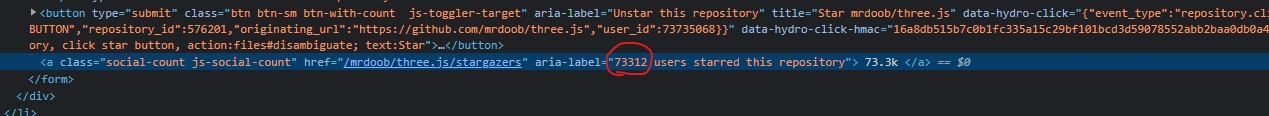
Forked count -
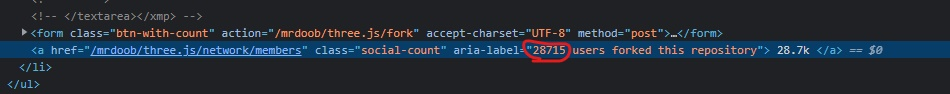
Last commited time - 
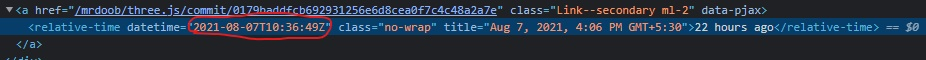
Total commits - 
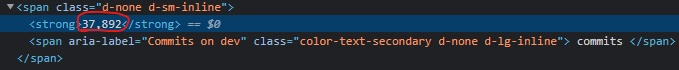

We can utilize <code>df_popular_repo['Repo_URL']</code> which we have already extracted, to extract remaining data.

In [11]:
repo_urls =df_popular_repo['Repo_URL']

Let's define a function <code>get_repo_info2(star_atags,forks_atags,commit_span_tags,last_commit_atag)</code> which returns us all the values we are expecting(as above).

In [12]:
def get_repo_info2(star_atags,forks_atags,commit_span_tags,last_commit_atag):
    stars = int(star_atags[0]['aria-label'].split()[0])
    forks = int(forks_atags[1]['aria-label'].split()[0])
    commits = int(commit_span_tags[1].strong.text.replace(',', '')) if len(commit_span_tags)==2 else int(commit_span_tags[0].strong.text.replace(',', ''))
    last_updated = last_commit_atag[0].find_all('relative-time')[0]['datetime'] if len(last_commit_atag)>=1 else None
    
    return stars,forks,commits,last_updated

The function <code>popular_repo_info2()</code> which we are going to define, loads the pages to get the required values ('Number_Of_Stars','Forked_Count', 'Total_Commits' and 'Last_Commited') and then returns a dataframe of these values.

In [13]:
def popular_repo_info2():
    repo_details2 ={'Number_Of_Stars':[],'Forked_count':[],'Total_commits':[],'Last_commited':[]}
    i=0
    while i<len(repo_urls):
        url = repo_urls[i]
        r =requests.get(url)
        if r.status_code != 200:
            print('Failed to load the page {}. Retrying...'.format(url))
            i-=1
        else:
            doc =BeautifulSoup(r.text, 'html.parser')
            
            star_atags = doc.find_all('a',{'class':'social-count js-social-count'})
            forks_atags =doc.find_all('a',{'class':'social-count'})
            commit_span_tags = doc.find_all('span',{'class':'d-none d-sm-inline'})
            last_commit_atag =doc.find_all('a',{'class':'Link--secondary ml-2'})

            repo_info2 = get_repo_info2(star_atags,forks_atags, commit_span_tags, last_commit_atag)
            repo_details2['Number_Of_Stars'].append(repo_info2[0])
            repo_details2['Forked_count'].append(repo_info2[1])
            repo_details2['Total_commits'].append(repo_info2[2])
            repo_details2['Last_commited'].append(repo_info2[3])
        i+=1
    
    return pd.DataFrame(repo_details2)

In [14]:
df_pop_repo_info2 = popular_repo_info2()
df_pop_repo_info2.head()

Number_Of_Stars  Forked_count  Total_commits         Last_commited
0            73315         28717          37892  2021-08-07T10:36:49Z
1             6931          1760            471  2021-01-03T19:57:17Z
2           189290         50833           1735  2021-07-31T17:45:09Z
3             3301           184           1385  2021-07-16T20:25:09Z
4           127040         18204          25370  2021-08-07T00:45:02Z

Now let's concat all these dataframes to get the final required outcome.

In [15]:
df = pd.concat([df_topics, df_popular_repo, df_pop_repo_info2], axis=1)
df.head()

Topics                                        Description  \
0         3D  3D modeling is the process of virtually develo...   
1       Ajax  Ajax is a technique for creating interactive w...   
2  Algorithm  Algorithms are self-contained sequences that c...   
3        Amp  Amp is a non-blocking concurrency framework fo...   
4    Android  Android is an operating system built by Google...   

                             Topic_URL Popular_repository(most_starred)  \
0         https://github.com/topics/3d                         three.js   
1       https://github.com/topics/ajax                  infinite-scroll   
2  https://github.com/topics/algorithm      coding-interview-university   
3      https://github.com/topics/amphp                              amp   
4    https://github.com/topics/android                          flutter   

  Repo_Username                                           Repo_URL  \
0        mrdoob                 https://github.com/mrdoob/three.js   
1     metafizzy       https://github.com/metafizzy/infinite-scroll   
2       jwasham  https://github.com/jwasham/coding-interview-un...   
3         amphp                       https://github.com/amphp/amp   
4       flutter                 https://github.com/flutter/flutter   

   Number_Of_Stars  Forked_count  Total_commits         Last_commited  
0            73315         28717          37892  2021-08-07T10:36:49Z  
1             6931          1760            471  2021-01-03T19:57:17Z  
2           189290         50833           1735  2021-07-31T17:45:09Z  
3             3301           184           1385  2021-07-16T20:25:09Z  
4           127040         18204          25370  2021-08-07T00:45:02Z

We have extracted all the required data. Now the final work is to store this data into a CSV file.

In [16]:
df.to_csv('Github_topics_detailed.csv')

Here we come to an end of this project.

<h3 align="center">Thank you...</h3>